# lab 1 | Regressions | Solutions

For your very first exercise in this course, you will try to predict the grades of students in a Portuguese school. For this, we will use (simplified) questionnaire data that you will first need to clean (a little).

Credit: [data source](https://archive.ics.uci.edu/ml/datasets/Student+Performance)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Load the dataset
students = pd.read_csv('student_grades.csv')
display(students.head())
students.shape

,male,age,address,parents_together,parents_avg_edu,classes_failed,school_support,absences,grade
0,0,18,U,0,4,0,yes,6.0,6
1,0,17,U,1,1,0,no,4.0,6
2,0,15,U,1,1,3,yes,10.0,10
3,0,15,U,1,3,0,no,2.0,15
4,0,16,U,1,3,0,no,4.0,10


(349, 9)

The dataset contains the following information:
- `male`: whether the student's sex is M or F (0, 1)
- `age`: the student's age (15-22)
- `address`: whether the student lives in an urban (U) or rural (R) setting
- `parents_together`: whether the parents live together or not
- `parents_avg_edu`: the rounded average of parental education
    - 0: none
    - 1: primary education (4th grade)
    - 2: 5th to 9th grade
    - 3: secondary education
    - 4: higher education
- `classes_failed`: the number of classes failed (n if 1 <= n < 3, else 4)
- `school_support`: extra educational support (yes, no)
- `absences`: number of school absences (0-93)
- `grade`: The student's grade (0-20)

In [2]:
# Q1: What is the type of data of each variable?
"""
Numerical discrete: age, absences, grade
Numerical continuous: N/A
Categorical ordinal: parents_avg_edu, classes_failed
Categorical nominal: male, address, parents_together, school_support
"""

'\nNumerical discrete: age, absences, grade\nNumerical continuous: N/A\nCategorical ordinal: parents_avg_edu, classes_failed\nCategorical nominal: male, address, parents_together, school_support\n'

Alright, now we can start with the EDA and data cleaning.

First, we notice that `address` and `school_support` are binary variables but do not have (1, 0) as their values. Do the following:
- Replace the `address` column with a binary column named `rural` that takes the value 1 if a students comes from a rural setting and 0 otherwise.
- In the `school_support` column, replace `yes` with `1` and `no` with `0`.

Make sure to double-check that the datatypes (of the entire dataframe) are correct once you are done. Is there any column that is not yet in the datatype it should be?

In [3]:
# Q2: Treat the binary columns that need to be formatted
# address to rural
students['rural'] = students['address'].eq('R').mul(1)
students.drop('address', axis=1, inplace=True)

# school_support value transformation
students['school_support'] = students['school_support'].eq('yes').mul(1)

# Print the datatypes
print(students.dtypes)

# Display the dataframe
students.head()

male                  int64
age                   int64
parents_together      int64
parents_avg_edu       int64
classes_failed        int64
school_support        int32
absences            float64
grade                 int64
rural                 int32
dtype: object


,male,age,parents_together,parents_avg_edu,classes_failed,school_support,absences,grade,rural
0,0,18,0,4,0,1,6.0,6,0
1,0,17,1,1,0,0,4.0,6,0
2,0,15,1,1,3,1,10.0,10,0
3,0,15,1,3,0,0,2.0,15,0
4,0,16,1,3,0,0,4.0,10,0


Now, look if there are missing values. If there are, replace them with the median value of the column.

In [4]:
# Q3: Treat the missing values
# Lookup the missing values
print(students.isna().sum())

# Input the median if needed
students['absences'].fillna(students['absences'].median(), inplace=True)

male                0
age                 0
parents_together    0
parents_avg_edu     0
classes_failed      0
school_support      0
absences            6
grade               0
rural               0
dtype: int64


Now, look up summary statistics for all variables and plot a histogram for them. Do you find any outliers? If so, remove the observation they occur in?

Hint: you should find exactly 1 outlier and it is easy to spot as it is outside of the possible values.

,male,age,parents_together,parents_avg_edu,classes_failed,school_support,absences,grade,rural
count,349.000000,349.00000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000
mean,0.475645,16.52149,0.891117,2.873926,0.318052,0.146132,5.911175,10.575931,0.180516
std,0.500123,1.21661,0.311939,0.983269,0.734409,0.353745,8.305975,4.975006,0.385169
min,0.000000,15.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,16.00000,1.000000,2.000000,0.000000,0.000000,0.000000,8.000000,0.000000
50%,0.000000,16.00000,1.000000,3.000000,0.000000,0.000000,4.000000,11.000000,0.000000
75%,1.000000,17.00000,1.000000,4.000000,0.000000,0.000000,8.000000,14.000000,0.000000
max,1.000000,22.00000,1.000000,4.000000,3.000000,1.000000,75.000000,45.000000,1.000000


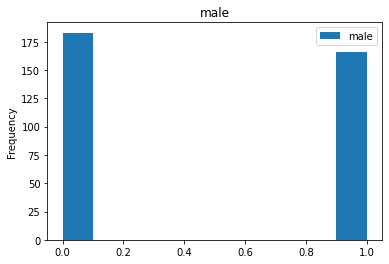

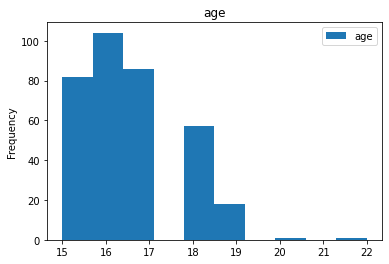

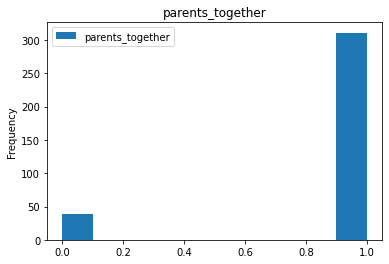

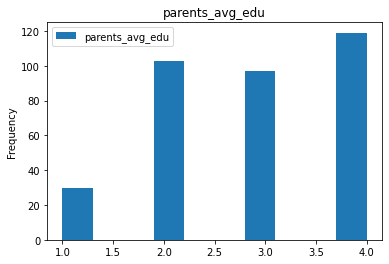

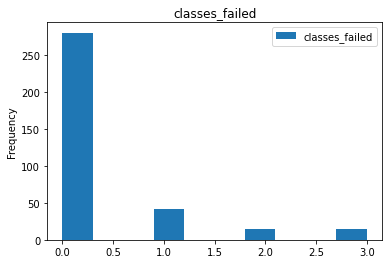

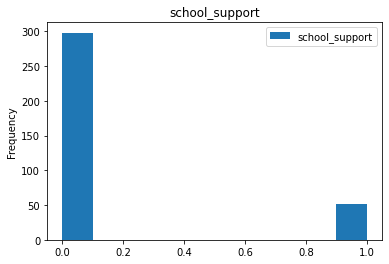

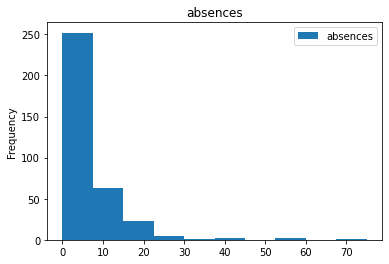

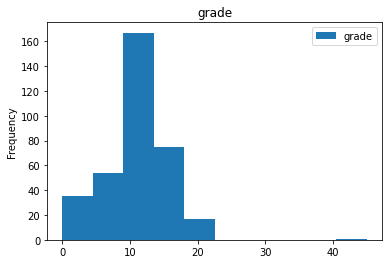

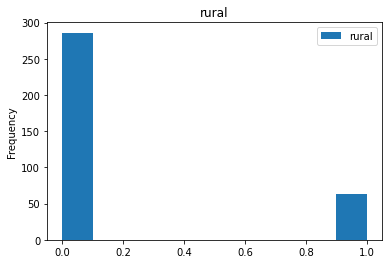

In [5]:
# Q4: Remove outliers
# display is used to show the output when a command follows it
display(students.describe())

# Plot all variables
for col in students.columns:
    students.plot(y=col, kind='hist', title=col)

# Remove the outlier
students = students[students['grade'] <= 20]

We would like to log-transform the dependent variable (i.e., `grade`). Since there are some students who received a 0, you will need to replace those values with an infinitely small positive number. Also, make sure the rename the `grade` column to `ln_grade`

In [6]:
# Q5: Log-transform the dependent variable
# Replace 0 with 0.0000001 in grades
students['grade'].replace({0: 0.0000001}, inplace=True)

# Log-transform grade
students['grade'] = np.log(students['grade'])

# Rename grade to ln_grade
students.rename(columns={'grade': 'ln_grade'}, inplace=True)

students

C:\Users\Jonas\AppData\Local\Temp\ipykernel_15596\1348642671.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  students['grade'].replace({0: 0.0000001}, inplace=True)
C:\Users\Jonas\AppData\Local\Temp\ipykernel_15596\1348642671.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  students['grade'] = np.log(students['grade'])
C:\Users\Jonas\AppData\Local\Temp\ipykernel_15596\1348642671.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

,male,age,parents_together,parents_avg_edu,classes_failed,school_support,absences,ln_grade,rural
0,0,18,0,4,0,1,6.0,1.791759,0
1,0,17,1,1,0,0,4.0,1.791759,0
2,0,15,1,1,3,1,10.0,2.302585,0
3,0,15,1,3,0,0,2.0,2.708050,0
4,0,16,1,3,0,0,4.0,2.302585,0
...,...,...,...,...,...,...,...,...,...
344,0,18,1,3,0,0,4.0,2.302585,0
345,0,18,1,3,0,0,7.0,2.639057,0
346,1,18,1,4,0,0,9.0,2.772589,1
347,1,18,1,4,0,0,0.0,2.197225,0


Finally, create two dummy variables out of `absences`:
- `some_abs`: 1 if `absences` is between 10 and 20 (included), 0 otherwise
- `many_abs`: 1 if `absences` is larger than 20, 0 otherwise

Think about why we do not create a third dummy variable for students with less than 10 absences.

Note: you are essentially asked to create two binary variables

In [7]:
# Q6: Create a dummy variable from 'absences'
# Create the some_abs column
students['some_abs'] = np.where(
    (students['absences'] >= 10) & (students['absences'] <= 20),
    1,
    0
)

# Create the many_abs column
students['many_abs'] = np.where(
    students['absences'] > 20,
    1,
    0
)

# Delete the absences column
students.drop('absences', axis=1, inplace=True)

students.head()

C:\Users\Jonas\AppData\Local\Temp\ipykernel_15596\4058235035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  students['some_abs'] = np.where(
C:\Users\Jonas\AppData\Local\Temp\ipykernel_15596\4058235035.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  students['many_abs'] = np.where(
C:\Users\Jonas\AppData\Local\Temp\ipykernel_15596\4058235035.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

,male,age,parents_together,parents_avg_edu,classes_failed,school_support,ln_grade,rural,some_abs,many_abs
0,0,18,0,4,0,1,1.791759,0,0,0
1,0,17,1,1,0,0,1.791759,0,0,0
2,0,15,1,1,3,1,2.302585,0,1,0
3,0,15,1,3,0,0,2.708050,0,0,0
4,0,16,1,3,0,0,2.302585,0,0,0


Alright, now we have a clean dataset that is ready for the actual machine learning part.

First, use the `statsmodels` library to compute a simple regression. In this case, we want you to regress `ln_grade` on all other variables without splitting the dataset. Hence, it should be just the way you ran regressions in your core statistics classes.

Interpret the results. Which coefficients are statistically significant? How do you interpret the coefficients?

In [8]:
# Q7: Regression
# Regress the log-grade on all variables and a constant
features = list(students.columns)
features.remove('ln_grade')
regression = smf.ols(f'ln_grade ~ {"+".join(features)}', data=students).fit()
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_grade   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     6.071
Date:                Fri, 13 Jan 2023   Prob (F-statistic):           6.49e-08
Time:                        08:30:36   Log-Likelihood:                -1061.5
No. Observations:                 348   AIC:                             2143.
Df Residuals:                     338   BIC:                             2182.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            8.0065      4.369  

Finally, we will try to determine which two features predict the grade the best. To do so, we will train the model iteratively over every pair of features and retain the ones with the best test MSE.

Simply complete the code below to determine which model is the best.

Note: This is an oversimplified version of determining the best model. In reality, there is no indication that 2 is the correct number of features and you might want to use more metrics than just the MSE to determine the best model. This is just so that you can get a first exposure to what this process looks like and gain intuition.

In [9]:
# Q8: Find the best 2-feature model
# Array to save the test errors
test_mse = pd.DataFrame(columns=['features', 'test_mse'])

# Feature pairs to evaluate
features = list(students.columns)
features.remove('ln_grade')
feature_pairs = []
for i, feature_1 in enumerate(features):
    for feature_2 in features[i+1:]:
        feature_pairs.append([feature_1, feature_2])

# Define the target
y = students['ln_grade']

# Iterate over the number of features
for feature_pair in feature_pairs:
    # Select features
    X_temp = students[feature_pair]

    # Split the dat set
    X_train, X_test, y_train, y_test = train_test_split(
        X_temp,
        y,
        test_size=0.2,
        random_state=12
    )

    # Create the linear model
    LR = LinearRegression(fit_intercept=True)

    # Fit the linear model
    LR.fit(X_train, y_train)
    
    # Compute the MSEs
    obs = pd.DataFrame({
        'features': [', '.join(feature_pair)],
        'test_mse': [mean_squared_error(y_test, LR.predict(X_test))]
    })

    test_mse = pd.concat([test_mse, obs], axis=0, ignore_index=True)

# Sort by MSEs
test_mse.sort_values(by='test_mse', axis=0, ascending=True, inplace=True)
test_mse

,features,test_mse
28,"classes_failed, some_abs",41.61682
24,"parents_avg_edu, some_abs",41.838745
35,"some_abs, many_abs",42.044727
6,"male, some_abs",42.124969
3,"male, classes_failed",42.268794
31,"school_support, some_abs",42.352197
16,"parents_together, classes_failed",42.37007
33,"rural, some_abs",42.383227
19,"parents_together, some_abs",42.438008
29,"classes_failed, many_abs",42.490415
